# Lyrics classifier

In [58]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import time
from scipy import sparse
import string 
punctuation_set = set(string.punctuation)

from nltk.corpus import stopwords
from nltk import pos_tag
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize, RegexpTokenizer 
import langid

import gensim
from gensim.models.ldamodel import LdaModel
from gensim.corpora import Dictionary

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)


from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from scipy.sparse import hstack
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB, GaussianNB
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelBinarizer
from xgboost import XGBClassifier

In [11]:
data = pd.read_csv('lyrics.csv')

In [12]:
data.head()

,index,song,year,artist,genre,lyrics
0,0,ego-remix,2009,beyonce-knowles,Pop,"Oh baby, how you doing?\nYou know I'm gonna cu..."
1,1,then-tell-me,2009,beyonce-knowles,Pop,"playin' everything so easy,\nit's like you see..."
2,2,honesty,2009,beyonce-knowles,Pop,If you search\nFor tenderness\nIt isn't hard t...
3,3,you-are-my-rock,2009,beyonce-knowles,Pop,"Oh oh oh I, oh oh oh I\n[Verse 1:]\nIf I wrote..."
4,4,black-culture,2009,beyonce-knowles,Pop,"Party the people, the people the party it's po..."


In [13]:
print('Shape of the dataframe: {}'.format(data.shape))

Shape of the dataframe: (362237, 6)


In [14]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 362237 entries, 0 to 362236
Data columns (total 6 columns):
index     362237 non-null int64
song      362235 non-null object
year      362237 non-null int64
artist    362237 non-null object
genre     362237 non-null object
lyrics    266557 non-null object
dtypes: int64(2), object(4)
memory usage: 16.6+ MB


**Quite a few missing values are present, especially in the lyrics column. This is understable since not all songs have lyrics available on Metrolyrics.**

In [15]:
data = data.drop('index',axis=1) # the index column is redundant

In [16]:
year_dist = data.year.value_counts()
print(year_dist.head())
print('Oldest song belongs to the year: {}'.format(year_dist.index.min()))
print('Latest song belongs to the year: {}'.format(year_dist.index.max()))

2006    76590
2007    63677
2016    37409
2015    28766
2014    28250
Name: year, dtype: int64
Oldest song belongs to the year: 67
Latest song belongs to the year: 2038


- Clearly there is something __*very*__ odd there! We need to do thorough a data cleaning exercise here it seems.

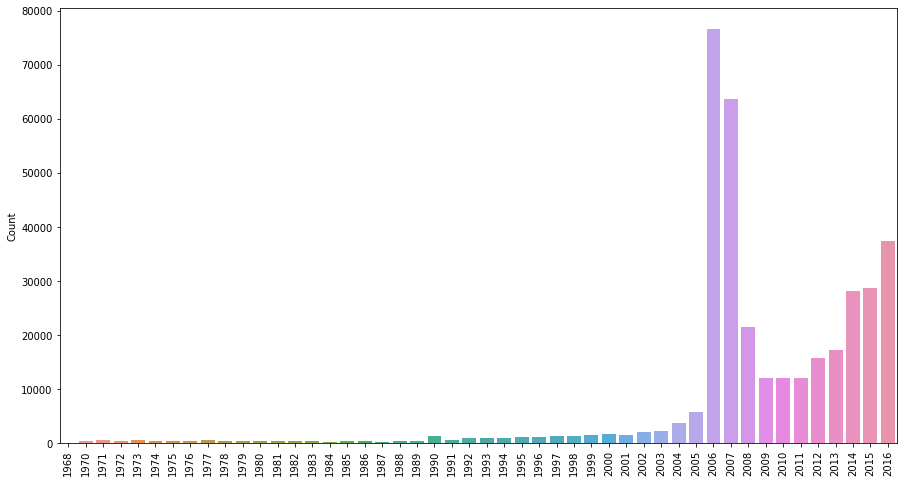

In [17]:
year_dist = year_dist.iloc[(year_dist.index>1900) & (year_dist.index <2019)]
plt.figure(figsize=(15,8))
_=sns.barplot(year_dist.index, year_dist)
_=plt.xticks(rotation='vertical')
_ = plt.ylabel('Count')

- Very few data points are available before 2005.

In [18]:
print('There are {} rows with missing lyrics.'.format(data.lyrics.isna().sum()))
data.loc[data.lyrics.isna()].head()

There are 95680 rows with missing lyrics.


,song,year,artist,genre,lyrics
158,lemonade,2016,beyonce-knowles,Pop,NaN
305,no-more-tears,2002,eazy-e,Hip-Hop,NaN
311,still-f-kem,2002,eazy-e,Hip-Hop,NaN
320,rev-skit,2002,eazy-e,Hip-Hop,NaN
338,hush-hush,2013,asher-monroe,Pop,NaN


#### There is no point keeping the rows with missing lyrics because the aim of this notebook is to analyze the lyrics of the songs and classify them. Therefore let's remove all the rows with missing lyrics.

In [19]:
data = data.dropna(axis=0, subset=['lyrics','song'])

In [20]:
data.shape

(266556, 5)

In [21]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 266556 entries, 0 to 362236
Data columns (total 5 columns):
song      266556 non-null object
year      266556 non-null int64
artist    266556 non-null object
genre     266556 non-null object
lyrics    266556 non-null object
dtypes: int64(1), object(4)
memory usage: 12.2+ MB


- No more missing values, Good to go!

### Distribution of the music genres
- Since we are interested in predicting the genre from the lyrics and other metadata available, let us first explore the 'target variable', i.e. the genre.

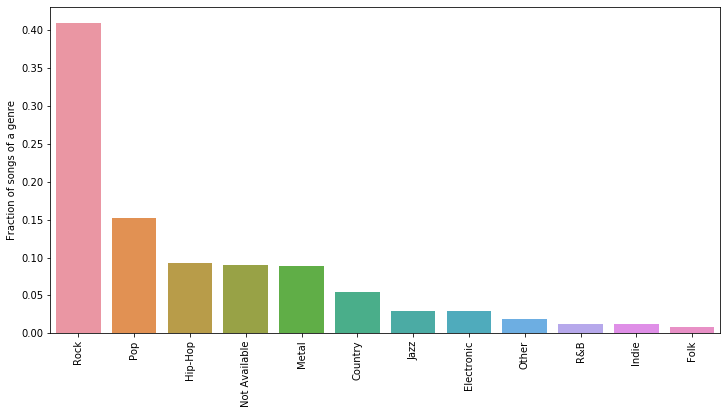

In [22]:
genre_count = data.genre.value_counts()
plt.figure(figsize=(12,6))
_=sns.barplot(genre_count.index, genre_count/len(data))
_=plt.xticks(rotation='vertical')
_=plt.ylabel('Fraction of songs of a genre')

- The dataset is highly imbalanced with respect to genre. 
 * More than 40% of the songs are rock, while less than 1% are folk songs. Says a lot about music preferences across the world in general? Mind you that the dataset is not restricted to English songs, it contains German, French and Spanish songs also.

In [23]:
# Filter out the rows that contain lyrics with less than 200 characters and genre is not available

data = data.loc[data.lyrics.map(len)> 200]
data = data.loc[~(data.genre == 'Not Available')]

In [24]:
data.shape

(234296, 5)

### Who are the top 10 artists?

In [25]:
pd.DataFrame(data.artist.value_counts()[:10])

,artist
dolly-parton,743
elton-john,643
chris-brown,621
barbra-streisand,602
eddy-arnold,589
bee-gees,586
bob-dylan,584
eminem,567
ella-fitzgerald,565
american-idol,562


### Data pre-processing

Next I would like to filter out all the non-English lyrics from the dataset to keep it simple, because:
- The number of non-English songs in the dataset is much smaller than that of English songs.
- It might introduce noise during song classification.
- When I tried topic modelling with lyrics of all languages, the LDA model, understandably, separated out the different languages as different topics, which is not what I want. In this context, homegeneity of the dataset is required to uncover the latent factors.

In [26]:
def is_english_lyrics(text):
    lang_clf = langid.classify(text)[0]
    eng_text =  lang_clf=='en'
    if eng_text:
        return 1
    else:
        return 0

In [160]:
data['english_lyrics'] = data['lyrics'].apply(lambda lyrics: is_english_lyrics(lyrics))

In [170]:
print('{} songs have English lyrics in the dataset'.format(data['english_lyrics'].sum()))  #How many songs have English lyrics

211401 songs have English lyrics in the dataset


In [162]:
#Only keep the English songs
data = data.loc[data['english_lyrics']==1, :].reset_index(drop=True)

### Text cleaning
- Remove stopwords
- Convert to lowercase and remove numbers and punctuations
- Keep only those words that are 3 characters or more in length
- Lemmatize the words with their appropriate part-of-speech

In [255]:
#from polyglot.detect import Detector

In [313]:
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()
tokenizer = RegexpTokenizer(r'([a-zA-Z]+)') 

from nltk.corpus import wordnet

def get_wordnet_pos(word):
    tag = pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}
    return tag_dict.get(tag, wordnet.NOUN)

def preprocess_text(lyrics):
    '''
    This function preprocesses the comments and sets them up for vectorization.
    Input: comment string
    Returns: A string after converting the words to lowercase, removing punctuations, and lemmatizing each word
    '''
    words = [word for word in tokenizer.tokenize(lyrics.lower()) if not word in stop_words]  # convert to lowercase and remove stopwords
    clean_words = [word for word in words if len(word)>2]
    lemmatized_lyrics = ' '.join([lemmatizer.lemmatize(word,pos= get_wordnet_pos(word)) for word in clean_words]) ## lemmatization
    return lemmatized_lyrics         

- We will now apply the preprocessing function to transform the 'lyrics' column.

In [165]:
start = time.time()
data['lyrics'] = data['lyrics'].apply(lambda lyrics: preprocess_text(lyrics))
print('Took {} secs.'.format(time.time() - start))

Took 4055.602637052536 secs.


- Only keep those lyrics which contain at least twenty words.

In [166]:
data = data.loc[data['lyrics'].apply(lambda words: len(words.split()))>20, :].reset_index(drop=True)

In [27]:
data.to_pickle("preprocessed_data.pkl")
#data = pd.read_pickle("preprocessed_data.pkl")

In [28]:
# Take a peek in to the cleaned lyrics column
clean_lyrics = data['lyrics']
clean_lyrics.head(10)

0    baby know gonna cut right chase woman make lik...
1    playin everything easy like seem sure still wa...
2    search tenderness hard find love need live loo...
3    verse write book stand title book would life s...
4    party people people party pop sit around see l...
5    heard church bell ring heard choir sing saw lo...
6    another day would spend waitin right one star ...
7    wait wait wait wait wait wait wait wait wait w...
8    verse read magazine wait around say wait see g...
9    honey well sit look around cause must bumped h...
Name: lyrics, dtype: object

## Topic modelling with Latent Dirichlet Allocation (LDA)
- The purpose of this section is to see if the unsupervised algorithm can separate out the genres based on the lyrics alone. That would be super cool!
- Note that LDA is not guaranteed to find out latent topics that are human interpretable. LDA generally works well when the underlying topics are disjoint. In lyrics topic modelling, I won't expect the LDA topics to coincide with all the specific genre lyrics very well.
- The other point to note is that it is difficult to gauge the effectiveness of techniques like LDA or LSA because they are unsupervised, that means there is no loss function which one can optimize.

In [69]:
#Create a dictionary of all the unique words in the corpus
tokenized_clean_lyrics = [word_tokenize(doc) for doc in clean_lyrics]
gensim_dict = Dictionary(tokenized_clean_lyrics)
gensim_dict.save('dictionary.dict')

/Users/debashis/anaconda3/lib/python3.6/site-packages/smart_open/smart_open_lib.py:398: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


In [70]:
#Now convert each document into the bag-of-words (BoW) format = list of (token_id, token_count).
corpus = [gensim_dict.doc2bow(doc) for doc in tokenized_clean_lyrics]
gensim.corpora.MmCorpus.serialize('corpus.mm', corpus)

#### LDA with count features
- We will create a LDA model with 10 topics (ambitious attempt). Why 10? Because there are 10 different genres in the dataset.

In [83]:
num_topics=10
start = time.time()
lda = LdaModel(corpus, id2word=gensim_dict, num_topics=num_topics, chunksize=2000, random_state=42)
lda.save('lda_10_topics.ldamodel')
#print((time.time() - start)/60, 'mins')

In [72]:
def show_topics(model,num_topics=10):
    ''' Input: LDA model, number of topics to display (default=10).
    Output: dataframe with LDA topics as columns
    '''
    topics = {}
    for i in range(num_topics):
        topics[i] = [tup[0] for tup in model.show_topic(i)]
    topics_lda_df = pd.DataFrame(data=topics)
    columns= ['Topic '+str(i+1) for i in range(num_topics)]
    topics_lda_df.columns = columns
    return topics_lda_df

In [73]:
show_topics(lda,10)

,Topic 1,Topic 2,Topic 3,Topic 4,Topic 5,Topic 6,Topic 7,Topic 8,Topic 9,Topic 10
0,life,light,blood,girl,love,old,say,get,na,get
1,one,come,kill,boy,heart,little,know,let,baby,like
2,god,like,dead,woman,know,new,get,know,gon,nigga
3,world,see,death,little,never,big,time,want,love,fuck
4,give,night,hell,like,feel,get,back,like,yeah,shit
5,live,eye,mind,lady,day,day,take,ta,wan,bitch
6,lord,sky,hate,mama,time,rock,come,got,get,cause
7,see,fall,fuck,whoa,dream,well,well,hey,make,money
8,soul,sun,pain,shake,one,town,think,feel,ooh,back
9,take,fire,black,pretty,away,two,never,right,give,know


__Which is which?__
- Topic3: Metal
- Topic 9: Pop/R&B
- Topic 10: Hip-Hop
- Topic 5: Rock/Jazz ?
- The other topics are not discernible to me.

### LDA with tf-idf features 

In [119]:
from gensim import models
tfidf = models.TfidfModel(corpus)  # This is basically the tf-idf vectorizer for gensim
corpus_tfidf = tfidf[corpus]   #(token id, tfidf score) for all the tokens in each docuemnt in the corpus

In [120]:
num_topics=10
start = time.time()
warnings.filterwarnings("ignore", category=DeprecationWarning)
lda_tfidf = LdaModel(corpus_tfidf, id2word=gensim_dict, num_topics=num_topics, chunksize=2000, random_state=42)
#lda_tfidf.save('lda_10_topics.ldamodel')
print((time.time() - start)/60, 'mins')


2.766523337364197 mins


In [121]:
data.genre.unique()

array(['Pop', 'Hip-Hop', 'Rock', 'Metal', 'Other', 'Country', 'Jazz',
       'Electronic', 'Folk', 'R&B', 'Indie'], dtype=object)

In [122]:
show_topics(lda_tfidf,num_topics=10)

,Topic 1,Topic 2,Topic 3,Topic 4,Topic 5,Topic 6,Topic 7,Topic 8,Topic 9,Topic 10
0,doo,death,keyboard,worship,love,christmas,beast,get,saturday,lil
1,careless,blood,coffee,bobby,know,merry,undone,nigga,papa,gal
2,forgiveness,horizon,sweeter,sacred,want,aah,thee,like,belongs,cowboy
3,unkind,parade,sentimental,endlessly,never,billy,truly,fuck,marry,dude
4,mem,flesh,santa,raven,time,andre,wolf,shit,awaits,saxophone
5,wedding,johnny,scatter,hurtin,feel,sincere,savior,na,hypnotize,fish
6,french,bleeding,boogie,git,heart,vine,christ,yeah,youve,jeff
7,tenderness,pressure,mornin,umbrella,away,honky,laughter,girl,term,dat
8,wisdom,evil,china,skyline,baby,gay,holy,gon,complicate,limit
9,badly,curtain,september,spiritual,say,opportunity,constant,bitch,sideways,realise


** Can you interpret the topics here?**
- Topic 8 sure looks like words out of a Hip-hop song. 
- Topic 2 contains words I'd rather associate with metal/death metal lyrics. 
- Topic 5 resembles pop.
- Topic 10 is Country (?).
- Rock lyrics is not clearly identifiable, probably because it does not have strong distinguishable features in terms of vocabulary. The same argument holds for Jazz.
- Indie is also a poorly defined genre in terms of lyrics used. 

It might be useful to re-run LDA with fewer topics, for e.g. 4 or 5.

#### In the visualisation below, we'll take a look at the most probable topic words within each topic

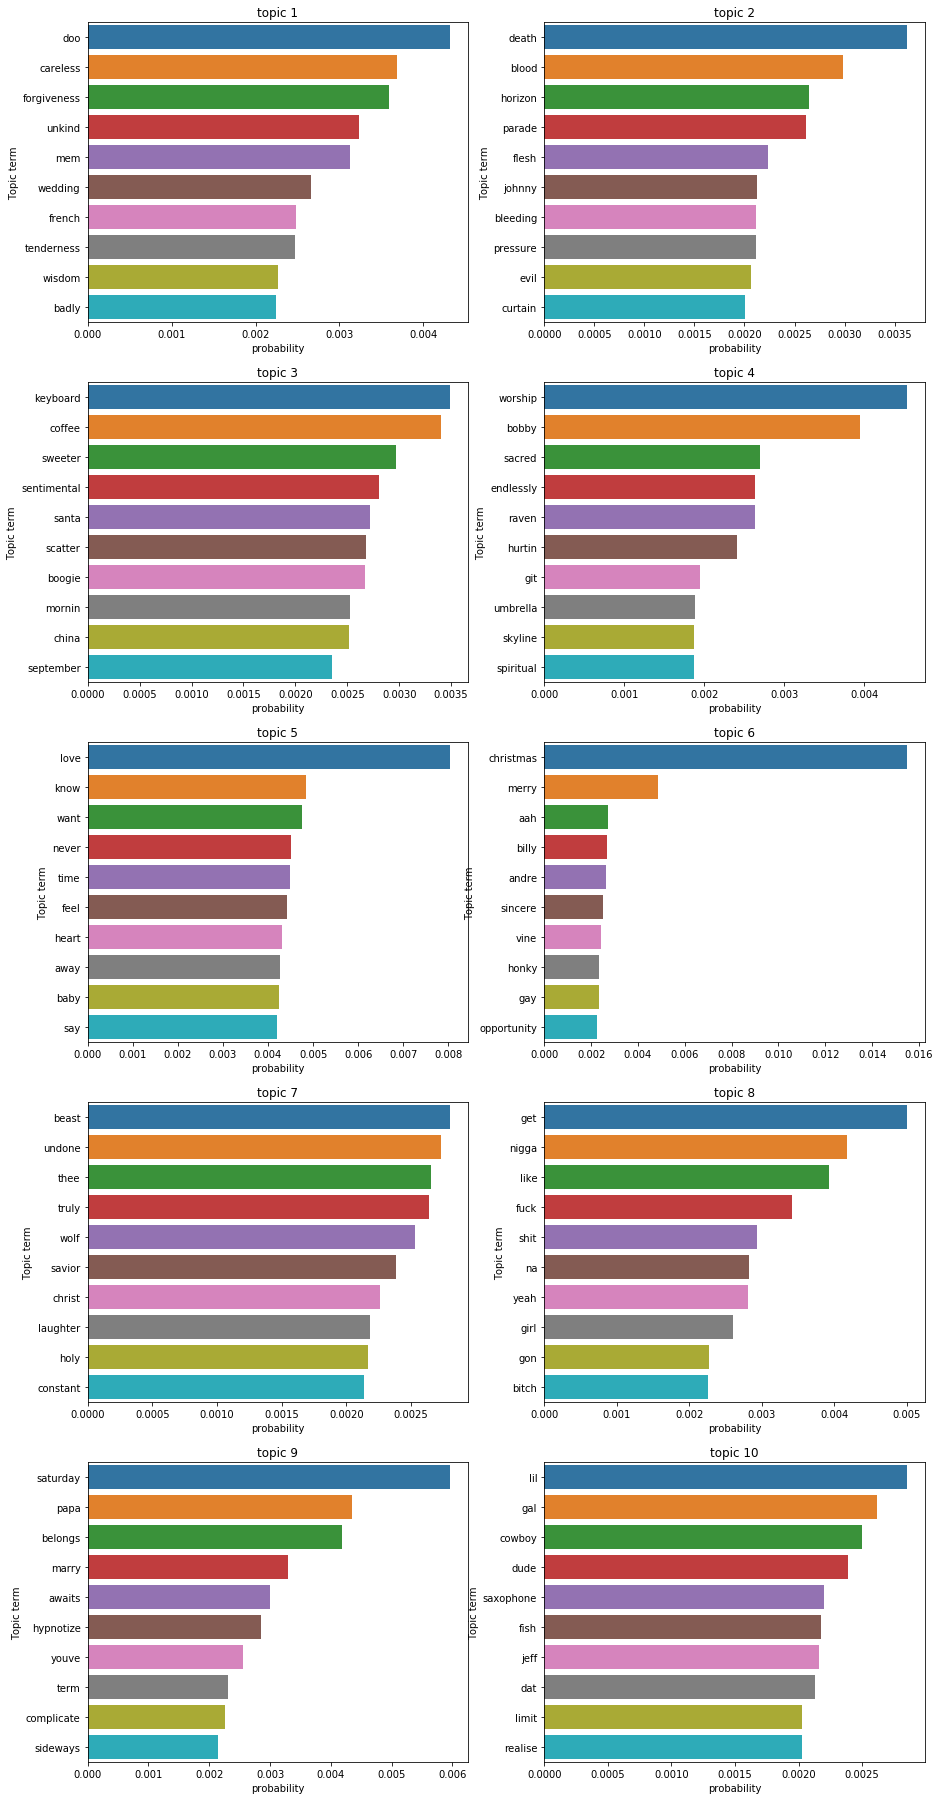

In [78]:
fig=plt.figure(figsize=(15,32))
for i in range(num_topics):
    df=pd.DataFrame(lda_tfidf.show_topic(i), columns=['term','prob']).set_index('term')    
    plt.subplot(5,2,i+1)
    plt.title('topic '+str(i+1))
    sns.barplot(x='prob', y=df.index, data=df)
    plt.xlabel('probability')
    plt.ylabel('Topic term')

### LDA visualisation with `pyLDAvis`
- LDAvis is a cool application to visualise the LDA topics and the inter-topic distances. It represents the topics as blobs on the first two principal components.

In [199]:
import pyLDAvis
pyLDAvis.enable_notebook()
import pyLDAvis.gensim

In [ ]:
start = time.time()
lda_display = pyLDAvis.gensim.prepare(lda_tfidf, corpus_tfidf, gensim_dict)
end = time.time()
print((end-start)/3600,'hrs')

In [ ]:
pyLDAvis.display(lda_display)

### Topic modelling with LSA

LSA uses singular value decomposition of the term-by-document matrix to identify a linear subspace in the space of tf-idf features that captures most of the variance in the collection. In fact LSA was widely used for topic modelling until the more sophisticated LDA was introduced in 2003.

With LSA or LSI, one can also perform dimensionality reduction such that most of the variance is retained. We will see this in a later section in the notebook.

In [43]:
from sklearn.decomposition import TruncatedSVD 
svd_model = TruncatedSVD(n_components=10, algorithm='randomized', n_iter=100, random_state=42) 
svd_model.fit(train_lyrics_features) 

TruncatedSVD(algorithm='randomized', n_components=10, n_iter=100,
             random_state=42, tol=0.0)

In [44]:
svd_model.components_.shape

(10, 50000)

In [45]:
terms = tfidf_vectorizer.get_feature_names() 
topics_lsa_dict = {}
for i, comp in enumerate(svd_model.components_): 
    terms_comp = zip(terms, comp) 
    sorted_terms = [tup[0] for tup in sorted(terms_comp, key= lambda x:x[1], reverse=True)[:10]]
    topics_lsa_dict[i] = sorted_terms

In [46]:
pd.DataFrame(topics_lsa_dict)

,0,1,2,3,4,5,6,7,8,9
0,get,nigga,blood,love,love,feel,god,away,baby,yeah
1,know,get,death,baby,nigga,yeah,life,day,say,yeah yeah
2,love,shit,nigga,night,heart,gonna,lord,back,back,love
3,like,fuck,god,yeah,love love,baby,well,gonna,cry,well
4,say,bitch,fuck,light,fuck,want,one,life,home,hey
5,see,yeah,soul,girl,give,let,world,time,leave,baby
6,time,money,black,come,shit,wanna,people,come,heart,love love
7,come,like,light,sky,bitch,get,give,take,please,cry
8,make,hit,dead,love love,feel,yeah yeah,yeah,long,lie,mind
9,one,wanna,life,dance,need,take,gonna,home,take,ooh


## Can we predict the genre given the lyrics?
- Removed the *Other, R&B, Indie and Folk* genres from the dataset as part of the data cleaning process.
- Split the dataset into train and test sets.
- One-hot encode the artist labels and scale (MinMaxScaler) the release year.

In [29]:
cond = (data.genre == 'Other') | (data.genre == 'Indie') | (data.genre == 'R&B') | (data.genre == 'Folk')
X = data.loc[~cond, ['year', 'artist', 'lyrics']]
y = data.loc[~cond, 'genre']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [30]:
ntrain = X_train.shape[0] # number of training examples

In [31]:
le = LabelBinarizer()
artist_ohe = le.fit_transform(X.artist)
artist_ohe_sparse = sparse.csr_matrix(artist_ohe)

from sklearn.preprocessing import MinMaxScaler

#scaler = MinMaxScaler()
#scaled_year = scaler.fit_transform(X.year.values.reshape(-1,1))
#scaled_year_sparse = sparse.csr_matrix(scaled_year)

### Tf-idf vectorization
- considered both unigrams and bi-grams.
- sublinear (logarithmic) term frequency is set to True.
- Only those words which occur in at least 20 documents.
- Only those words which occur in < 70% of all the documents are considered.
- Max 50000 features are considered.

In [60]:
tfidf_vectorizer = TfidfVectorizer(
    strip_accents= 'unicode', analyzer='word', min_df = 20, max_df = 0.6, ngram_range=(1, 2), sublinear_tf=True,                                  
     max_features=50000)

In [61]:
train_lyrics_features = tfidf_vectorizer.fit_transform(X_train['lyrics'])
test_lyrics_features = tfidf_vectorizer.transform(X_test['lyrics'])

feature_names = tfidf_vectorizer.get_feature_names()

__Adding the artist encodings and the release years actually decreased performance of the classifiers. Therefore I decided to stick to just the lyrics. __

In [62]:
train_features_full = sparse.hstack([train_lyrics_features])
test_features_full = sparse.hstack([test_lyrics_features])

#train_features_full = sparse.hstack([train_lyrics_features, artist_ohe_sparse[:ntrain]])
#test_features_full = sparse.hstack([test_lyrics_features, artist_ohe_sparse[ntrain:]])

- Write a function to do grid search and fit the model with the best parameters found.

In [67]:
from sklearn.model_selection import GridSearchCV
def grid_search(clf, parameters, X, y, n_jobs=-1, n_folds=5, score_func=None,verbose=0):
    if score_func:
        gs = GridSearchCV(clf, param_grid=parameters, cv=n_folds, n_jobs=n_jobs, scoring=score_func,verbose =verbose)
    else:
        gs = GridSearchCV(clf, param_grid=parameters, cv=n_folds, verbose =verbose)
    gs.fit(X, y)
    print ("Best parameter values: {} and best score = {}".format(gs.best_params_ , gs.best_score_))
    best = gs.best_estimator_
    return best

#### Naive Bayes

In [52]:
clf_mulNB = MultinomialNB()
parameters = {'alpha': np.arange(0.0001, 0.001,0.0001)}
mulNB_model = grid_search(clf_mulNB, parameters, train_features_full, y_train, n_folds=10, score_func='accuracy')

Best parameter values: {'alpha': 0.0008} and best score = 0.635845132332235


In [53]:
clf_mulNB_pred = mulNB_model.predict(test_features_full)

In [38]:
def report(target, model_pred):
    print(classification_report(target, model_pred))
    genres_list = ['Pop', 'Rock', 'Metal', 'Electronic', 'Country', 'Hip-Hop', 'Jazz']
    cm = confusion_matrix(target,model_pred, labels = genres_list)
    display(pd.DataFrame(cm, columns = genres_list, index = genres_list))

In [54]:
report(y_test,clf_mulNB_pred)

              precision    recall  f1-score   support

     Country       0.62      0.20      0.30      4225
  Electronic       0.91      0.03      0.06      1858
     Hip-Hop       0.78      0.78      0.78      6610
        Jazz       0.52      0.24      0.33      2090
       Metal       0.67      0.58      0.63      6139
         Pop       0.50      0.31      0.38      9958
        Rock       0.63      0.86      0.73     29084

    accuracy                           0.64     59964
   macro avg       0.66      0.43      0.46     59964
weighted avg       0.64      0.64      0.60     59964



,Pop,Rock,Metal,Electronic,Country,Hip-Hop,Jazz
Pop,3065,5940,171,2,98,497,185
Rock,1612,25075,1305,2,328,565,197
Metal,83,2308,3588,0,3,157,0
Electronic,287,1264,112,59,0,134,2
Country,323,2900,42,0,837,48,75
Hip-Hop,491,893,69,2,5,5141,9
Jazz,247,1183,31,0,78,53,498


#### Logistic Regression

In [65]:
clf_logreg = LogisticRegression(solver='sag', multi_class='ovr', random_state=42)
parameters = {'C': np.arange(1,11,1)}
logreg_model = grid_search(clf_logreg, parameters, train_features_full, y_train, n_folds=5, score_func='accuracy')

Best parameter values: {'C': 3} and best score = 0.6552286063482307


In [66]:
logreg_model.fit(train_features_full,y_train)
logreg_pred = logreg_model.predict(test_features_full)

In [156]:
report(y_test, logreg_pred)
accuracy_score(y_test, logreg_pred)

              precision    recall  f1-score   support

     Country       0.62      0.31      0.41      4225
  Electronic       0.69      0.05      0.10      1858
     Hip-Hop       0.88      0.81      0.84      6610
        Jazz       0.61      0.25      0.36      2090
       Metal       0.74      0.56      0.63      6139
         Pop       0.51      0.37      0.42      9958
        Rock       0.65      0.87      0.74     29084

    accuracy                           0.66     59964
   macro avg       0.67      0.46      0.50     59964
weighted avg       0.66      0.66      0.63     59964



,Pop,Rock,Metal,Electronic,Country,Hip-Hop,Jazz
Pop,3643,5587,113,15,170,323,107
Rock,1994,25243,950,15,510,210,162
Metal,159,2428,3431,5,10,106,0
Electronic,349,1251,81,95,8,72,2
Country,346,2473,20,2,1315,13,56
Hip-Hop,426,774,54,5,16,5330,5
Jazz,275,1141,19,0,103,22,530


0.6601794409979321

#### Interpretation
- The overall accuracy is 0.66, which by itself is not that bad considering how nuanced the lyrics in certain genres can be. For e.g. can you tell a jazz lyrics from a rock lyrics without listeing to the music? 

- The Hip-Hop genre was expected from our topic modelling studies to have both a high precision and a high recall, and we find exactly that. In fact, it has the highest precision and recall value among all the genres. Why? Because of the cuss words that you mostly find in Hip-Hop.

- For Metal, precision is relatively high at 74%, because of few false positives (take a look at the numbers in the Metal column). But it suffers from low recall because of the high number of false negatives. Specifically, 2428 Metal lyrics were classified as Rock, or, in other words,  90% of the false positives were mis-classified as Rock.

- The recall for Electronic genre is really low, with most 'Electronic' lyrics getting classified as Rock. I guess this has to do with the fact that most of the lyrics in the dataset were from the Rock genre.

*The performance of the logistic regression classifier is similar to that of the Naive Bayes, with the overall metrics being slightly better for Log-Reg.*

### XGBoost

In [177]:
y_train_labels = y_train.map({'Pop':1, 'Rock':2, 'Metal':3, 'Electronic':4, 'Country':5, 'Hip-Hop':6, 'Jazz':7})
y_test_labels = y_test.map({'Pop':1, 'Rock':2, 'Metal':3, 'Electronic':4, 'Country':5, 'Hip-Hop':6, 'Jazz':7})

In [213]:
clf_xgb = XGBClassifier(n_estimators=100, max_depth=5, colsample_bytree=0.5, n_jobs=3)

In [222]:
clf_xgb.fit(train_features_full,y_train_labels)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.5, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=5,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='multi:softprob', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [223]:
clf_xgb_pred = clf_xgb.predict(test_features_full)

In [180]:
print(classification_report(y_train_labels,clf_xgb.predict(train_features_full),target_names = genres_list))

In [228]:
print(classification_report(y_test_labels,clf_xgb_pred,target_names = genres_list))
cm_xgb = confusion_matrix(y_test_labels,clf_xgb_pred)
pd.DataFrame(cm_xgb, columns = genres_list, index = genres_list)

              precision    recall  f1-score   support

         Pop       0.56      0.17      0.26     10222
        Rock       0.58      0.95      0.72     29768
       Metal       0.77      0.35      0.48      6135
  Electronic       0.95      0.01      0.02      1961
     Country       0.79      0.08      0.15      4225
     Hip-Hop       0.85      0.75      0.80      6731
        Jazz       0.60      0.05      0.09      2163

    accuracy                           0.62     61205
   macro avg       0.73      0.34      0.36     61205
weighted avg       0.65      0.62      0.54     61205



In [233]:
cm_xgb = confusion_matrix(y_test_labels,clf_xgb_pred)
pd.DataFrame(cm_xgb, columns = genres_list, index = genres_list)

,Pop,Rock,Metal,Electronic,Country,Hip-Hop,Jazz
Pop,1719,8007,61,0,11,395,29
Rock,574,28323,509,0,72,262,28
Metal,43,3853,2133,0,1,104,1
Electronic,131,1694,22,21,2,91,0
Country,89,3743,15,0,356,9,13
Hip-Hop,403,1258,20,1,1,5048,0
Jazz,101,1908,10,0,9,27,108


## Classification with LDA features

In [171]:
from sklearn.decomposition import LatentDirichletAllocation
lda = LatentDirichletAllocation(n_components = 100)
lda_weights_train = lda.fit_transform(train_features_full)
lda_weights_test = lda.transform(test_features_full)

In [197]:
clf_logreg_lda = LogisticRegression(solver='sag', multi_class='ovr', random_state=42)
params = {'C': np.arange(0.1,5,0.5)}
logreg_lda = grid_search(clf_logreg_lda, params, lda_weights_train, y_train, n_folds=5, score_func='accuracy')
clf_logreg_lda_pred = logreg_lda.predict(lda_weights_test)

Best parameter values: {'C': 4.6} and best score = 0.5620063896850186


In [198]:
report(y_test, clf_logreg_lda_pred)
accuracy_score(y_test, clf_logreg_lda_pred)

              precision    recall  f1-score   support

     Country       0.40      0.00      0.00      4225
  Electronic       0.00      0.00      0.00      1858
     Hip-Hop       0.76      0.64      0.70      6610
        Jazz       0.46      0.06      0.10      2090
       Metal       0.62      0.35      0.45      6139
         Pop       0.33      0.01      0.02      9958
        Rock       0.54      0.94      0.69     29084

    accuracy                           0.57     59964
   macro avg       0.44      0.29      0.28     59964
weighted avg       0.51      0.57      0.46     59964



,Pop,Rock,Metal,Electronic,Country,Hip-Hop,Jazz
Pop,117,9241,199,1,0,356,44
Rock,98,27364,920,0,6,641,55
Metal,0,3849,2145,0,0,144,1
Electronic,9,1703,60,0,0,80,6
Country,60,3961,69,0,4,105,26
Hip-Hop,17,2308,20,0,0,4260,5
Jazz,54,1838,33,1,0,49,115


0.5670902541524915

## Classification with LSA features

In this section, I will use LSA as purely a dimensionality reduction feature and then classify the lyrics in the reduced feature space.

In [148]:
svd_model = TruncatedSVD(n_components=500, n_iter=100, random_state=42) 

In [149]:
svd_train = svd_model.fit_transform(train_lyrics_features)
svd_test = svd_model.transform(test_lyrics_features) 

In [150]:
print(train_lyrics_features.shape)
print(svd_train.shape)

(139913, 50000)
(139913, 500)


In [154]:
clf_logreg_svd = LogisticRegression(solver='sag', multi_class='ovr', random_state=42)
params = {'C': np.arange(2,31,2)}
logreg_svd = grid_search(clf_logreg_svd, params, svd_train, y_train, n_folds=5, score_func='accuracy')

Best parameter values: {'C': 28} and best score = 0.6295769513912217


In [155]:
logreg_svd_pred = logreg_svd.predict(svd_test)
report(y_test, logreg_svd_pred)
accuracy_score(y_test, logreg_svd_pred)

              precision    recall  f1-score   support

     Country       0.54      0.16      0.25      4225
  Electronic       0.44      0.00      0.01      1858
     Hip-Hop       0.85      0.78      0.81      6610
        Jazz       0.47      0.10      0.17      2090
       Metal       0.73      0.51      0.60      6139
         Pop       0.49      0.24      0.32      9958
        Rock       0.61      0.90      0.73     29084

    accuracy                           0.63     59964
   macro avg       0.59      0.39      0.41     59964
weighted avg       0.61      0.63      0.58     59964



,Pop,Rock,Metal,Electronic,Country,Hip-Hop,Jazz
Pop,2372,6871,115,2,127,409,62
Rock,1237,26252,890,1,346,254,104
Metal,96,2784,3143,0,5,110,1
Electronic,230,1455,71,8,5,82,7
Country,278,3171,27,0,684,6,59
Hip-Hop,421,973,59,7,10,5137,3
Jazz,220,1524,17,0,92,24,213


0.6305283169901941

Only a `~3%` drop in accuracy. Impressive performance by SVD coupled with Logistic regression. 
- I chose logistic regression for this task because it was the best performing classifier in the previous section.